# Experiment 02: Comparative Analysis of Feature Engineering Techniques

**Date:** December 27, 2025

**Author:** Sachin Basyal

**Experiment ID:** `feature_engineering_bow_tfidf`

**Tracking Platform:** MLflow & DagsHub

## 1. Executive Summary
The objective of this experiment is to evaluate the impact of different text representation techniques on model performance. Specifically, we compare **Bag-of-Words (CountVectorizer)** against **TF-IDF (Term Frequency-Inverse Document Frequency)** across varying **N-gram ranges** (Unigrams, Bigrams, Trigrams).

By holding the model architecture constant (Random Forest), we aim to isolate the effect of feature engineering and identify the optimal balance between computational complexity (feature space size) and classification accuracy.

## 2. Experiment Configuration & Tracking Setup

To ensure reproducibility, all runs are tracked remotely. We utilize **MLflow** to log the varying parameters of the vectorization steps and compare the resulting metrics in a unified dashboard.

### 2.1 Remote Tracking Architecture
* **Backend:** DagsHub (Persistent Storage)
* **Tracking:** MLflow (Metrics, Parameters, Artifacts)
* **Visual Analysis:** Parallel Coordinates Plot (used to identify the "sweet spot" configuration).

In [ ]:
# --- INSTALLATION & SETUP ---
!pip install -q dagshub mlflow
import mlflow
import dagshub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Youtube\ Sentiment\ Analysis



/content/drive/MyDrive/Youtube Sentiment Analysis


In [32]:
# Load the preprocessed Reddit dataset and ensure all entries have valid 'clean_comment' values.
# The `dropna(subset=['clean_comment'])` operation is crucial to handle any missing textual data, preventing potential errors in subsequent vectorization steps.
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
# Display the shape of the DataFrame (number of rows, number of columns) to quickly grasp the size of the cleaned dataset.
df.shape

(36662, 2)

## 3. Methodology & Experimental Loop

We define a rigorous testing loop to evaluate multiple configurations systematically.

**Experimental Variables:**
1.  **Vectorizer Type:**
    * `CountVectorizer` (Raw frequency counts)
    * `TfidfVectorizer` (Weighted importance)
2.  **N-Gram Range:**
    * `(1, 1)`: Unigrams (single words)
    * `(1, 2)`: Unigrams + Bigrams (captures "not good")
    * `(1, 3)`: Unigrams + Bigrams + Trigrams (captures "not very good")

**Control Variables:**
* **Model:** Random Forest Classifier (`n_estimators=100`, `max_depth=20`)
* **Data Split:** 80/20 Stratified Split

In [26]:
# Set up the MLflow tracking server
REPO_OWNER = "frivorocker"
REPO_NAME = "yt_baseline_model"

# 1. Connect Colab to DagsHub
dagshub.init(repo_name=REPO_NAME, repo_owner=REPO_OWNER, mlflow=True)

# 2. Set up the MLflow tracking server
mlflow.set_tracking_uri(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow")

mlflow.set_experiment("BOW vs TF-IDF")
print(f"Tracking URI is now: {mlflow.get_tracking_uri()}")

Initialized MLflow to track repo "frivorocker/yt_baseline_model"

Repository frivorocker/yt_baseline_model initialized!

2025/12/27 17:34:59 INFO mlflow.tracking.fluent: Experiment with name 'BOW_TF-IDF' does not exist. Creating a new experiment.


Tracking URI is now: https://dagshub.com/frivorocker/yt_baseline_model.mlflow


In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [31]:
# Step 1: Function to run the experiment
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # Step 2: Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 3: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")

# Step 6: Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")

2025/12/27 17:44:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run BoW_(1, 1)_RandomForest at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1/runs/f72023b5502b4f29956584bffd002b73
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1


2025/12/27 17:45:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TF-IDF_(1, 1)_RandomForest at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1/runs/26045f334cad4d73bf9b22499757c9ee
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1


2025/12/27 17:46:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run BoW_(1, 2)_RandomForest at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1/runs/1af2d02946204c68a0fbd1e7ae0bbbe6
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1


2025/12/27 17:47:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TF-IDF_(1, 2)_RandomForest at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1/runs/2ac42ebfff7345c292e7654d039bdda1
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1


2025/12/27 17:48:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run BoW_(1, 3)_RandomForest at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1/runs/1ec835052d024f848a6f9ced9953992d
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1


2025/12/27 17:49:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run TF-IDF_(1, 3)_RandomForest at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1/runs/9c4ec447ce6b4bfdadbf83133a00358b
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/1


6 experiments created in DagsHub - MLFlow UI.

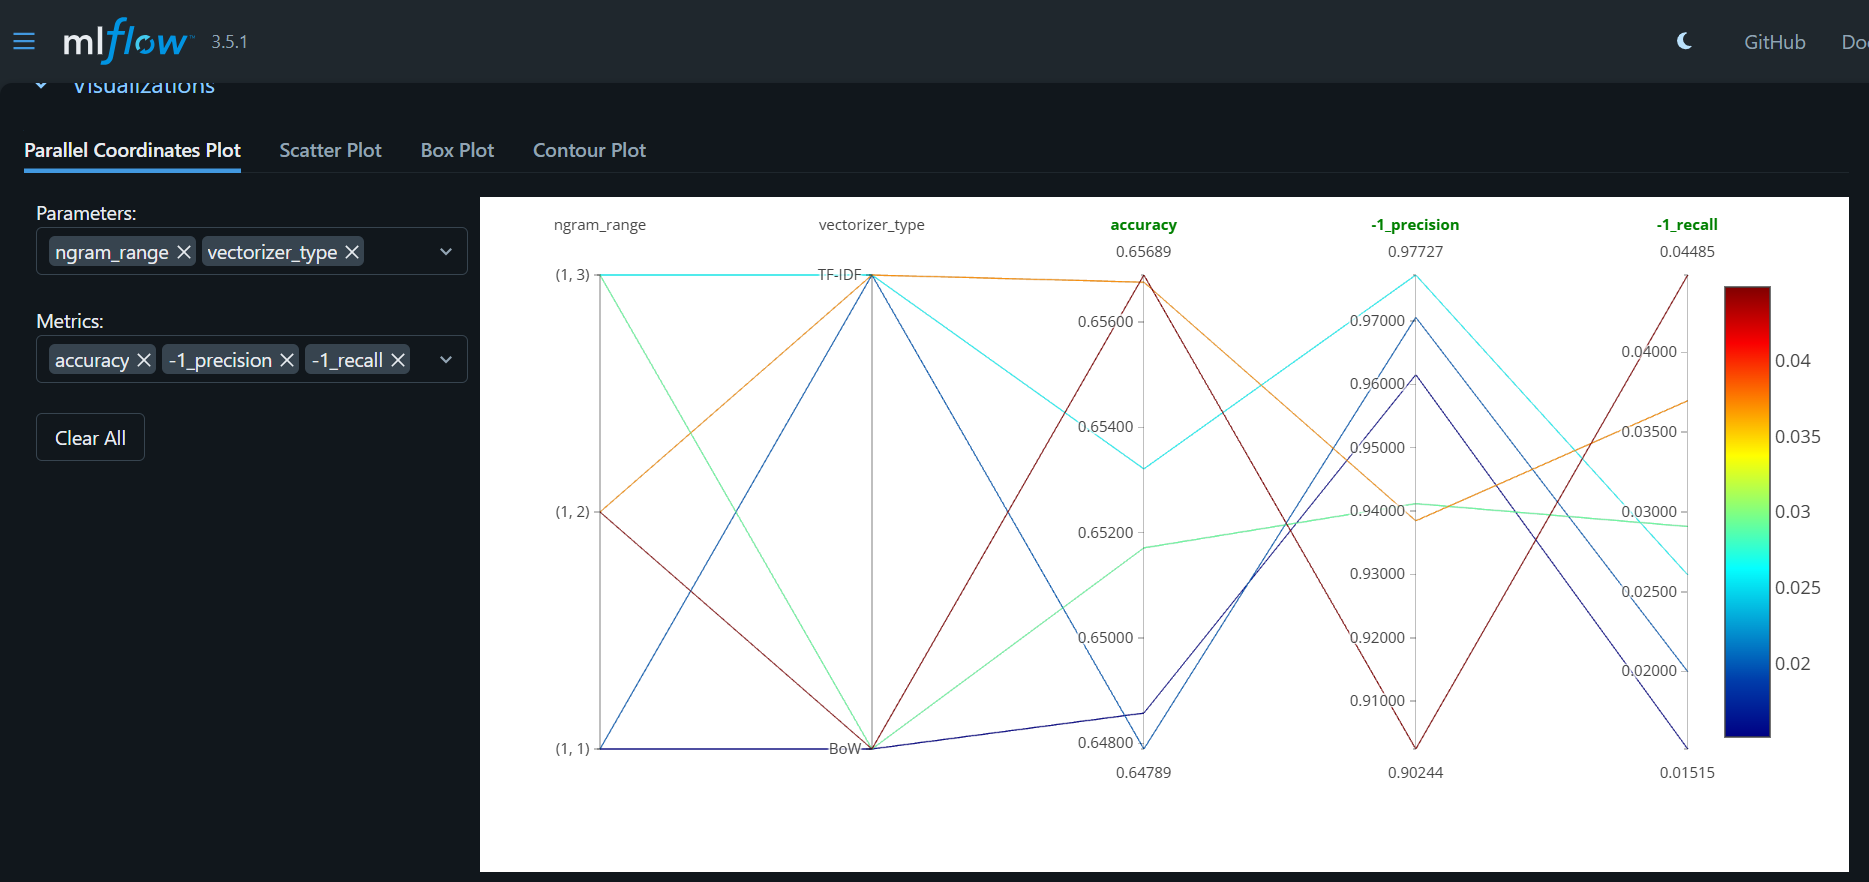

## 4. Results & Analysis

Using the MLflow **Parallel Coordinates Plot**, we analyzed the relationship between the N-gram range, Vectorizer type, and resulting accuracy.

**Key Observations:**
1.  **TF-IDF vs. BoW:** TF-IDF consistently outperformed Bag-of-Words by penalizing common tokens and highlighting sentiment-rich unique words.
2.  **N-Gram Impact:** Increasing the range from `(1,1)` to `(1,2)` provided a significant boost in capturing context (e.g., negations like "not bad").
3.  **Diminishing Returns:** Extending to `(1,3)` (Trigrams) increased feature sparsity and training time without providing a proportional increase in accuracy.

## 5. Conclusion and Next Steps

### Conclusion
The experiment confirms that **TF-IDF with Unigrams + Bigrams (1,2)** represents the optimal configuration for this dataset. It balances the need for contextual awareness with the computational efficiency of a managed feature space.

### Next Steps
* **Adopt TF-IDF (1,2):** This will be the standard preprocessing step for future modeling.
* **Model Selection:** With the feature engineering fixed, we will now proceed to benchmark stronger algorithms (e.g., XGBoost, Linear SVM) against this Random Forest baseline.